### Initialization for Real-Time Bitcoin Analysis

This code initializes the environment for a real-time Bitcoin price analysis project using the Streamz library.

It begins by disabling the Streamz IPython widget to avoid potential rendering issues. Then, it imports essential Python libraries:

In [ ]:
#PREAMBLE: disable Streamz IPython widget to avoid AttributeError
from streamz.core import Stream as _Stream
_Stream._ipython_display_ = lambda self, **kwargs: None
# Install dependencies
!pip install yfinance scikit-learn --quiet


# Imports & constants
import requests
import pandas as pd
import numpy as np
import time, random
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

from sklearn.ensemble     import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics      import classification_report, accuracy_score

from streamz import Stream

# API endpoints & params
CRYPTOCOMPARE_API_URL       = "https://min-api.cryptocompare.com/data/price"
CRYPTOCOMPARE_DETAIL_URL    = "https://min-api.cryptocompare.com/data/pricemultifull"
CRYPTOCOMPARE_PARAMS        = {'fsym':'BTC','tsyms':'USD','extraParams':'BTCTrendNotebook'}
CRYPTOCOMPARE_DETAIL_PARAMS = {'fsyms':'BTC','tsyms':'USD','extraParams':'BTCTrendNotebook'}

# Timing & analytics settings
POLL_INTERVAL_SECONDS = 5    # fetch every 5 s
SHORT_WINDOW         = 5
MEDIUM_WINDOW        = 10
LONG_WINDOW          = 20
ALERT_THRESHOLD_PCT  = 0.5   # 0.5% move
cols = ['timestamp','price_usd','market_cap_usd','24h_volume_usd','24h_change_percent']



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Function to Fetch Real-Time Bitcoin Data

This code defines a function `fetch_bitcoin_data()` responsible for retrieving the latest Bitcoin price and related data from the CryptoCompare API.


In [ ]:
# Fetch one record from CryptoCompare
def fetch_bitcoin_data():
    try:
        price = requests.get(CRYPTOCOMPARE_API_URL, params=CRYPTOCOMPARE_PARAMS, timeout=10) \
                       .json().get('USD', np.nan)
        raw   = requests.get(CRYPTOCOMPARE_DETAIL_URL, params=CRYPTOCOMPARE_DETAIL_PARAMS, timeout=10) \
                       .json().get('RAW',{}).get('BTC',{}).get('USD',{})
        return {
            'timestamp'          : datetime.now(),
            'price_usd'          : price,
            'market_cap_usd'     : raw.get('MKTCAP', np.nan),
            '24h_volume_usd'     : raw.get('VOLUME24HOUR', np.nan),
            '24h_change_percent' : raw.get('CHANGEPCT24HOUR', np.nan)
        }
    except Exception as e:
        print("Fetch error:", e)
        return None


### Feature Engineering Function and Streamz Pipeline Setup

This section defines the logic for calculating important technical analysis features from the real-time price data and sets up the initial Streamz pipeline to continuously accumulate the incoming data into a Pandas DataFrame and then apply the feature engineering function to it. The `enhanced` stream will carry the DataFrames with the calculated features for further processing, such as alerts and visualization.

In [ ]:
# Accumulate + feature engineering
def add_features(df):
    df = df.copy()
    df['short_ma']  = df['price_usd'].rolling(window=min(SHORT_WINDOW, len(df))).mean()
    if len(df) >= MEDIUM_WINDOW:
        df['medium_ma'] = df['price_usd'].rolling(window=MEDIUM_WINDOW).mean()
    if len(df) >= LONG_WINDOW:
        df['long_ma']   = df['price_usd'].rolling(window=LONG_WINDOW).mean()
    df['momentum']   = df['price_usd'].pct_change().mul(100)
    df['volatility'] = df['price_usd'].rolling(window=min(10, len(df))).std()
    return df

# create source and pipeline
source    = Stream()
df_stream = source.accumulate(
    lambda df, rec: pd.concat([df, pd.DataFrame([rec])], ignore_index=True),
    start=pd.DataFrame(columns=cols)
)
enhanced = df_stream.map(add_features)

## Alerting & Visualization

- **Alerts** when price jumps ≥ threshold or moving-average crossovers occur  
- **Plot** price + MAs and momentum in two stacked panels  

These sections define two parallel branches in the Streamz pipeline. One branch processes the data to check for and trigger alerts based on price movements and moving average crossovers, while the other branch takes the same processed data and generates a dynamic, real-time visualization of the Bitcoin price and momentum. The use of `map()` creates new streams where these functions are applied, and the `sink()` operations ensure that the computations are executed whenever new data flows through the pipeline.

In [ ]:
# Alerts
alerts_stream = enhanced.map(check_alerts)
alerts_stream.sink(lambda x: None) # Sink to trigger the map function

def check_alerts(df):
    if len(df) < 2: return
    change = (df['price_usd'].iloc[-1]/df['price_usd'].iloc[-2] - 1) * 100
    if abs(change) >= ALERT_THRESHOLD_PCT:
        dirn = "up" if change>0 else "down"
        print(f"🚨 ALERT: Price moved {dirn} by {abs(change):.2f}%!")
    if 'short_ma' in df and 'medium_ma' in df and len(df)>MEDIUM_WINDOW:
        prev = df['short_ma'].iloc[-2] - df['medium_ma'].iloc[-2]
        curr = df['short_ma'].iloc[-1] - df['medium_ma'].iloc[-1]
        if prev<=0<curr:
            print("🚨 Bullish crossover!")
        if prev>=0>curr:
            print("🚨 Bearish crossover!")

# Visualization
visualization_stream = enhanced.map(visualize_data)
visualization_stream.sink(lambda x: None) # Sink to trigger the map function

def visualize_data(df):
    clear_output(wait=True)
    latest = df.iloc[-1]
    print(f"Last update: {latest['timestamp'].strftime('%H:%M:%S')} | Price: ${latest['price_usd']:.2f}")
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8),
                                   gridspec_kw={'height_ratios':[3,1]})
    ax1.plot(df['timestamp'], df['price_usd'], label='Price')
    for ma in ['short_ma','medium_ma','long_ma']:
        if ma in df: ax1.plot(df['timestamp'], df[ma], label=ma)
    ax1.legend(); ax1.set_title("BTC/USD & MAs")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax2.plot(df['timestamp'], df['momentum'], label='Momentum')
    ax2.axhline(0, color='gray', alpha=0.3)
    ax2.set_title("Momentum (%)"); ax2.set_xlabel("Time"); ax2.legend()
    plt.tight_layout(); plt.show()



## Run the Stream

Emits a new record every interval; interrupt the kernel to stop.

In essence, this section contains the main execution loop of the real-time data analysis. It continuously fetches Bitcoin price data at a specified interval, injects this data into the Streamz pipeline for processing, and includes a mechanism for the user to stop the script cleanly.

Last update: 14:03:41 | Price: $103222.30


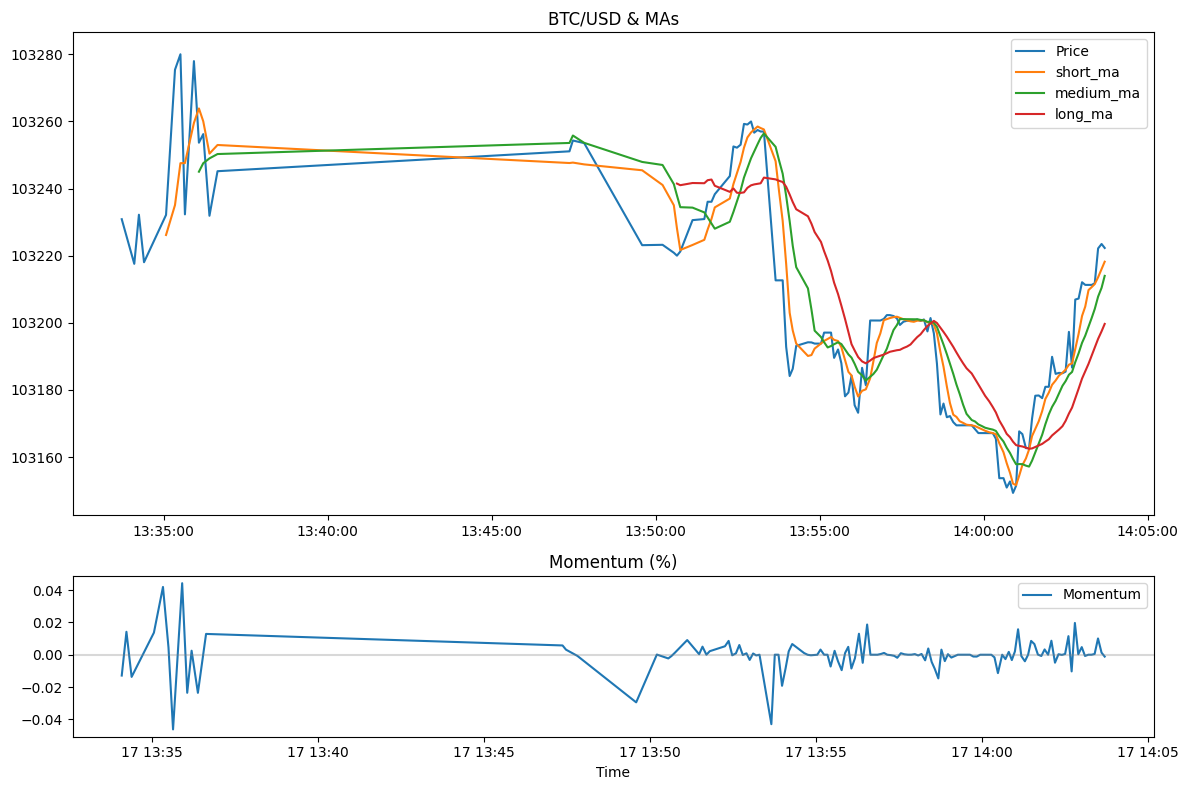


Stopped by user.


In [11]:
print(f"Starting… fetching every {POLL_INTERVAL_SECONDS}s (Ctrl+C to stop)")
try:
    while True:
        rec = fetch_bitcoin_data()
        if rec: source.emit(rec)
        jitter = POLL_INTERVAL_SECONDS*0.1*(2*(0.5-random.random()))
        time.sleep(POLL_INTERVAL_SECONDS + jitter)
except KeyboardInterrupt:
    print("\nStopped by user.")


### Output Explanation of the Real-Time Bitcoin Price and Momentum Chart

The generated chart displays the real-time analysis of Bitcoin (BTC/USD) price and its momentum over a short period. It consists of two subplots:

**Top Subplot: BTC/USD & MAs**

This subplot visualizes the Bitcoin price along with its short-term, medium-term, and long-term moving averages (MAs).

1.  **Price (Blue Line):** The solid blue line represents the real-time fluctuating price of Bitcoin against the US Dollar.

2.  **short\_ma (Orange Line):** The orange line shows the short-term moving average of the Bitcoin price. This is calculated over a smaller window (e.g., 5 periods) and is more responsive to recent price changes.

3.  **medium\_ma (Green Line):** The green line represents the medium-term moving average, calculated over a larger window (e.g., 10 periods). It smooths out the price fluctuations more than the short-term MA and helps identify intermediate trends.

4.  **long\_ma (Red Line):** The red line shows the long-term moving average, calculated over the largest window (e.g., 20 periods). It provides a smoother view of the overall trend and is less sensitive to short-term volatility.

5.  **Time (X-axis):** The horizontal axis represents the time, showing the progression of the real-time data.

6.  **Price (Y-axis):** The vertical axis represents the price of Bitcoin in US Dollars.

7.  **Legend (Top Right):** Explains which line corresponds to the price and each of the moving averages.

**Bottom Subplot: Momentum (%)**

This subplot displays the momentum of the Bitcoin price.

1.  **Momentum (Blue Line):** The blue line represents the percentage change in the Bitcoin price over a specific period (likely the percentage change from the previous data point). It indicates the speed and strength of the price movement.

2.  **Zero Line (Grey Horizontal Line):** The horizontal grey line at y=0 acts as a reference point. Momentum above zero suggests an upward price trend, while momentum below zero suggests a downward trend. The further the momentum line is from zero, the stronger the price movement.

3.  **Time (X-axis):** The horizontal axis aligns with the top subplot, showing the same time progression.

4.  **Momentum (%) (Y-axis):** The vertical axis represents the percentage change in price, indicating the momentum.

5.  **Legend (Bottom Right):** Explains that the blue line represents the momentum.

**Interpretation:**

This chart provides a real-time snapshot of Bitcoin's price action and its momentum. Traders often use moving averages to identify trends and potential buy/sell signals (e.g., crossovers of MAs). The momentum indicator helps gauge the strength and direction of the current price movement. By observing both subplots, one can get a sense of the immediate price dynamics and potential short-term trends in the Bitcoin market. The dynamic nature of this chart (updating with new real-time data) allows for continuous monitoring of these indicators.

-------------

 ### Fibonacci Analysis Setup: Ratios, Rolling Window, and Historical Data Download

 configures the Fibonacci ratios to be used, sets the rolling window size for identifying price swings, and downloads historical daily Bitcoin price data from Yahoo Finance, storing it in a Pandas DataFrame named `df` with renamed columns for high, low, and closing prices. This historical data will be used for the Fibonacci retracement analysis.

In [25]:
# Fibonacci ratios and rolling window
FIB_RATIOS    = [0, 0.236, 0.382, 0.5, 0.618, 1.0]
ROLLING_WINDOW = 50  # days to define swing high/low
# Download historical BTC-USD daily data
df = yf.download("BTC-USD",
                 start="2023-01-01",
                 end="2025-05-01",
                 progress=False)[['High','Low','Close']]
df.rename(columns={'High':'high','Low':'low','Close':'close'}, inplace=True)


### Computing Swing Highs/Lows, Fibonacci Levels, and Normalized Distance Features
This section calculates swing highs and lows using a rolling window, determines the Fibonacci retracement levels based on these swings, computes the normalized distance of the closing price to each Fibonacci level, stores these normalized distances in a separate DataFrame, and then merges these new features back into the main historical price DataFrame. Finally, it prints the head of both the main DataFrame and the normalized distance features (starting after the rolling window effect) for inspection.

In [ ]:
# Compute swing highs/lows, Fibonacci levels, and merge in distance features

# Rolling swing highs and lows
swing_high = df[('high', 'BTC-USD')].rolling(ROLLING_WINDOW).max()
swing_low  = df[('low', 'BTC-USD')].rolling(ROLLING_WINDOW).min()
diff       = swing_high - swing_low

# Fibonacci retracement levels
for ratio in FIB_RATIOS:
    lvl_col = f'fib_{int(ratio*100)}'
    df[lvl_col] = swing_high - diff * ratio

# Build normalized distance-to-level features in a separate DataFrame
dist_df = pd.DataFrame(index=df.index)
for ratio in FIB_RATIOS[1:-1]:  # skip 0% and 100%
    lvl_col  = f'fib_{int(ratio*100)}'
    dist_col = f'fib_dist_{int(ratio*100)}'

    close_series = df[('close', 'BTC-USD')]  # Access 'close' with the MultiIndex
    lvl_series = df[lvl_col]

    distance = (close_series - lvl_series).abs()
    width_series = diff.replace(0, np.nan)

    # normalized distance series
    if isinstance(distance, pd.Series) and isinstance(width, pd.Series):
        dist_df[dist_col] = distance.div(width)
    else:
        print(f"Error: 'distance' or 'width' is not a pandas Series for ratio {ratio}")
        print(f"Type of 'distance': {type(distance)}")
        print(f"Type of 'width': {type(width)}")
        dist_df[dist_col] = np.nan  # Assign NaN if there's an issue

# Concatenate back into main DataFrame
df = pd.concat([df, dist_df], axis=1)

print("--- Head of df (first 10 rows) ---")
print(df.head(10))
print("\n--- Normalized Distance Features (starting from row 50) ---")
print(dist_df.iloc[49:].head())

--- Head of df (first 10 rows) ---
            (high, BTC-USD)  (low, BTC-USD)  (close, BTC-USD)  (fib_0, )  \
Date                                                                       
2023-01-01     16630.439453    16521.234375      16625.080078        NaN   
2023-01-02     16759.343750    16572.228516      16688.470703        NaN   
2023-01-03     16760.447266    16622.371094      16679.857422        NaN   
2023-01-04     16964.585938    16667.763672      16863.238281        NaN   
2023-01-05     16884.021484    16790.283203      16836.736328        NaN   
2023-01-06     16991.994141    16716.421875      16951.968750        NaN   
2023-01-07     16975.017578    16914.191406      16955.078125        NaN   
2023-01-08     17091.144531    16924.050781      17091.144531        NaN   
2023-01-09     17389.957031    17093.992188      17196.554688        NaN   
2023-01-10     17484.720703    17162.990234      17446.292969        NaN   

            (fib_23, )  (fib_38, )  (fib_50, )  (fib

**Observation:**

The output of the first 10 rows of the DataFrame (`df.head(10)`) shows `NaN` (Not a Number) values in the columns related to Fibonacci levels (`fib_0` to `fib_100`) and the normalized distance features (`fib_dist_23` to `fib_dist_61`). However, the output of the normalized distance features starting from the 50th row (`dist_df.iloc[49:].head()`) begins to show numerical values.

**Reasoning:**

The `NaN` values in the initial rows are an expected outcome of the rolling window calculation used to determine the swing highs and lows. The `ROLLING_WINDOW` is set to 50 days. This means that for the first 49 days of the dataset, there aren't enough preceding data points to calculate a 50-day rolling maximum and minimum. Consequently:

* `swing_high` and `swing_low` will be `NaN` for these initial rows.
* The `diff` (swing high - swing low) will also be `NaN`.
* Since the Fibonacci levels are calculated using `swing_high` and `diff`, these columns will also contain `NaN` for the first 49 rows.
* Similarly, the normalized distance features, which rely on the Fibonacci levels and the `diff`, will also be `NaN` during this initial period.

**Confirmation of Correct Calculation:**

The fact that numerical values start appearing in the `fib_dist_XX` columns from the 50th row onwards confirms that the calculations for the Fibonacci levels and the normalized distances are working correctly. Once the rolling window has 50 days of data to operate on, it can compute the swing highs and lows, and subsequently, the Fibonacci levels and the normalized distances become calculable.

**Summary:**

The initial `NaN` values are not an error but a natural consequence of the rolling window approach. The appearance of numerical values after the first 49 rows indicates that the Fibonacci analysis calculations have been successfully implemented once sufficient historical data is available for the rolling window.

### Plotting Fibonacci Retracement with Potential Buy/Sell Zones
In essence, this section generates a visualization of the Bitcoin price history, overlays the calculated Fibonacci retracement levels, and attempts to highlight regions where potential buying or selling opportunities might have occurred based on simplified interactions with these levels after price swings. It's important to note that the buy/sell region identification is a basic illustration and not a sophisticated trading strategy.


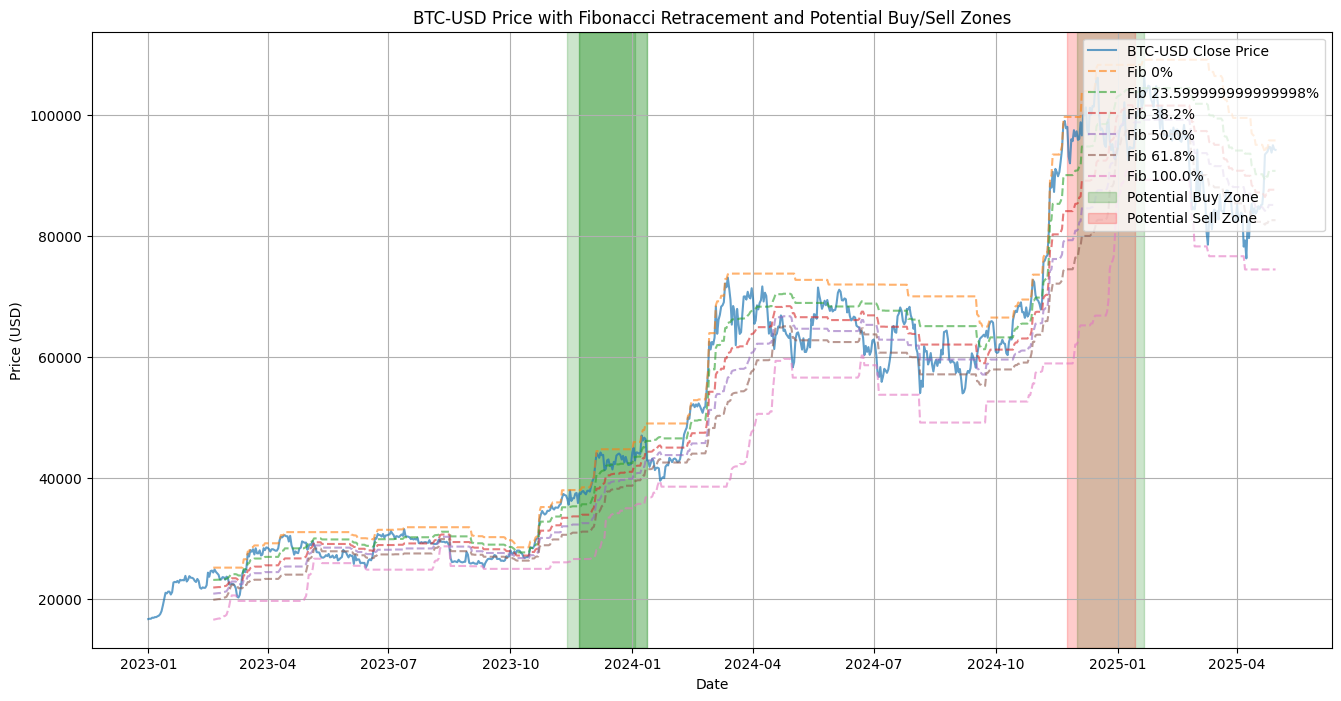

In [ ]:
# Ensure swing_high and swing_low are calculated
swing_high = df[('high', 'BTC-USD')].rolling(ROLLING_WINDOW).max()
swing_low  = df[('low', 'BTC-USD')].rolling(ROLLING_WINDOW).min()

# Create the plot
plt.figure(figsize=(16, 8))
plt.plot(df.index, df[('close', 'BTC-USD')], label='BTC-USD Close Price', alpha=0.7)

# Plot Fibonacci levels
for ratio in FIB_RATIOS:
    lvl_col = f'fib_{int(ratio*100)}'
    plt.plot(df.index, df[lvl_col], label=f'Fib {ratio*100}%', linestyle='--', alpha=0.6)

# Highlight potential buy and sell regions (simplified approach)
# We'll look for instances where the price touches/bounces off Fibonacci levels
# after a significant swing (defined by the swing high/low).

# This is a very basic and illustrative approach. Real trading strategies
# would involve more sophisticated criteria.

buy_regions = []
sell_regions = []
in_swing = False
swing_start_index = None
swing_high_val = -np.inf
swing_low_val = np.inf

for i in range(ROLLING_WINDOW, len(df)):
    current_high = df[('high', 'BTC-USD')].iloc[i]
    current_low = df[('low', 'BTC-USD')].iloc[i]
    current_close = df[('close', 'BTC-USD')].iloc[i]

    prev_high = swing_high.iloc[i - 1]
    prev_low = swing_low.iloc[i - 1]

    # Detect potential swing high
    if current_high >= prev_high and not in_swing:
        in_swing = True
        swing_start_index = df.index[i - ROLLING_WINDOW] # Approximate start
        swing_high_val = current_high
        swing_low_val = np.inf
    elif current_high < prev_high and in_swing and swing_high_val != -np.inf:
        # Potential drop after swing high - look for interaction with fib levels
        for ratio in [0.382, 0.5, 0.618]:
            fib_level = df[f'fib_{int(ratio*100)}'].iloc[i]
            if current_low <= fib_level <= current_high:
                buy_regions.append((swing_start_index, df.index[i]))
        in_swing = False
        swing_high_val = -np.inf

    # Detect potential swing low (similar logic)
    if current_low <= prev_low and not in_swing:
        in_swing = True
        swing_start_index = df.index[i - ROLLING_WINDOW] # Approximate start
        swing_low_val = current_low
        swing_high_val = -np.inf
    elif current_low > prev_low and in_swing and swing_low_val != np.inf:
        # Potential rise after swing low - look for interaction with fib levels
        for ratio in [0.382, 0.5, 0.618]:
            fib_level = df[f'fib_{int(ratio*100)}'].iloc[i]
            if current_low <= fib_level <= current_high:
                sell_regions.append((swing_start_index, df.index[i]))
        in_swing = False
        swing_low_val = np.inf

# Plot highlighted regions
for start, end in buy_regions:
    plt.axvspan(start, end, color='green', alpha=0.2, label='Potential Buy Zone' if (start, end) == buy_regions[0] else "")
for start, end in sell_regions:
    plt.axvspan(start, end, color='red', alpha=0.2, label='Potential Sell Zone' if (start, end) == sell_regions[0] else "")

plt.title('BTC-USD Price with Fibonacci Retracement and Potential Buy/Sell Zones')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

---
Imagine a ball rolling up a hill (a price increase) and then starting to roll back down (a price decrease). Fibonacci retracement levels are like invisible lines on that hill that some people believe the ball might stop or slow down at during its roll back.

These lines aren't just placed randomly. They're based on a special sequence of numbers called the Fibonacci sequence. The most common retracement levels are 23.6%, 38.2%, 50%, 61.8%, and sometimes 78.6% of the original climb.

### Overview of a Scenario:

Imagine a stock has been trading around $50. Then, due to some positive news, it experiences a strong upward move to $70. This $20 ($70 - $50) increase is our initial price swing. Now, the price starts to pull back down.

Traders using Fibonacci retracement would draw levels based on this $20 swing, anchored at the high ($70) and the low ($50$):

* **61.8% Retracement Level:** $70 - (0.618 \times $20) = $70 - $12.36 = $57.64
* **50% Retracement Level:** $70 - (0.50 \times $20) = $70 - $10 = $60.00
* **38.2% Retracement Level:** $70 - (0.382 \times $20) = $70 - $7.64 = $62.36
* **23.6% Retracement Level:** $70 - (0.236 \times $20) = $70 - $4.72 = $65.28

### Potential Trading Decisions:

As the price starts to fall from $70, a trader might watch these Fibonacci levels for potential **buying opportunities**, anticipating that the price might find support at one of these levels and then resume its upward trend.

* **Aggressive traders** might consider a buy order near the 23.6% or 38.2% retracement levels ($65.28 or $62.36), expecting a shallow pullback. However, these levels have a higher risk of being broken.

* **More conservative traders** might wait for the price to reach the 50% or 61.8% retracement levels ($60.00 or $57.64$). These levels are often considered stronger areas of potential support. If the price reaches these levels and shows signs of bouncing back up (e.g., bullish candlestick patterns), it could be considered a more favorable time to buy, with a stop-loss order placed below the Fibonacci level to manage risk.

---

### Output Explanation of the Bitcoin Price Chart with Fibonacci Retracement

The generated chart visualizes the historical price of Bitcoin (BTC-USD) from January 2023 to May 2025, overlaid with Fibonacci retracement levels and highlighted potential buy and sell zones. Here's a breakdown of the elements:

1.  **BTC-USD Close Price (Blue Line):** Represents the daily closing price of Bitcoin over the plotted period.

2.  **Fibonacci Retracement Levels (Dashed Lines):** Colored dashed lines indicating Fibonacci retracement levels (0%, 23.6%, 38.2%, 50.0%, 61.8%, 100%) calculated based on rolling 50-day swing highs and lows. These are potential support and resistance areas.

    * **Fib 0.0% (Orange Dashed):** Swing high.
    * **Fib 23.6% (Green Dashed):** 23.6% retracement.
    * **Fib 38.2% (Green Dashed):** 38.2% retracement.
    * **Fib 50.0% (Purple Dashed):** 50% retracement.
    * **Fib 61.8% (Purple Dashed):** 61.8% retracement (key level).
    * **Fib 100.0% (Orange Dashed):** Swing low.

3.  **Potential Buy Zones (Green Shaded Regions):** Semi-transparent green vertical bands highlighting periods where the price dropped after a swing high and interacted with Fibonacci support levels.

4.  **Potential Sell Zones (Red Shaded Regions):** Semi-transparent red vertical bands highlighting periods where the price rose after a swing low and interacted with Fibonacci resistance levels.

5.  **Date (X-axis):** Timeframe from January 2023 to May 2025.

6.  **Price (USD) (Y-axis):** Bitcoin price in US Dollars.

7.  **Legend (Top Right):** Explains the different lines and shaded regions.

8.  **Grid:** Grey lines for better readability of price levels and dates.

**Interpretation:**

The chart illustrates how Fibonacci retracement levels might coincide with potential buying and selling opportunities after price swings. Price interactions with these levels can suggest areas of support or resistance.

**Important Notes:**

* The buy/sell zone identification is based on a simplified algorithm.
* Fibonacci levels are dynamic due to the rolling window calculation.
* Fibonacci retracement is a reactive tool and not a guaranteed predictor of future price movements.

This visualization provides a basic understanding of Fibonacci retracement applied to Bitcoin's price history, highlighting potential areas of interest based on this technical analysis technique. It's a simplified illustration and not intended as trading advice.